In [1]:
import pandas as pd
import os
import json
import csv
import re, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import ast
from datetime import datetime

from global_functions import *

In [2]:
FIGS_PATH = 'figs'+os.sep+'RQ2'
if not os.path.exists(FIGS_PATH):
    os.makedirs(FIGS_PATH)

In [3]:
release_creation_ts_all = get_release_dates()

yearly_releases = get_yearly_releases()

release_creation_ts_rolling = get_rolling_releases()
rolling_releases=get_rolling_releases()

In [4]:
def version_successor(release):
    if release=='4.8':
        return '4.9'
    return yearly_releases[yearly_releases.index(release)+1]

def version_successor_rolling(release):
    if release=='4.10':
        return '4.11'
    return rolling_releases[rolling_releases.index(release)+1]
   
def version_predecessor(release):
    return yearly_releases[yearly_releases.index(release)-1]    
     
    

In [5]:
#Load data
df_all = pd.read_csv('.'+os.sep+'data'+os.sep+'bugs_info.zip',index_col=False,compression='zip',dtype={'release':str,'version':str})
df_all = df_all.fillna('')
df_all = trans_to_datetime(df_all,['creation_time','first_assignment_date','last_assignment_date',
                          'first_resolved_date','last_resolved_date',
                           'first_fixed_date','last_fixed_date'])
df_all.head(n=2)

,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_resolved_date,first_fixed_date,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field
0,475361,4.5,Platform,2015-08-19 10:50:25,4.5,FIXED,0,1,1,NaT,...,2015-08-19 11:53:03,2015-08-19 11:53:03,2015-08-19 11:53:03,,0,0,4.5,4.5,False,False
1,475365,4.6,Platform,2015-08-19 11:34:37,4.6,FIXED,0,1,1,NaT,...,2015-08-26 14:29:30,2015-08-26 14:29:30,2015-08-26 14:29:30,,0,0,4.6,4.6,False,False


In [6]:
#all expect these in rolling releases
df=df_all[(df_all['release']!='4.9') & (df_all['release']!='4.10')]
#bugs in rolling release
df_rolling=df_all[(df_all['release']=='4.9') | (df_all['release']=='4.10')]

In [7]:
temp_rolling={  "4.9"  : "2018-09-19 00:00:00",
        "4.10" : "2018-12-19 00:00:00",
        "4.11" : "2019-03-20 00:00:00"}

In [8]:
def get_triaging_statistics_per_release(df_w,assignedFirst,resolvedFirst):
    #Calculate traiging time per release
    df_ret=pd.DataFrame()
    df_w['release'] = df_w['release'].astype(str)
    
    if assignedFirst:
        assingment_column = 'first_assignment_date'
    else:
        assingment_column = 'last_assignment_date'
        
        
    if resolvedFirst:
        resolve_column = 'first_resolved_date'
    else:
        resolve_column = 'last_resolved_date'
        
        
    for version in df_w.release.unique():
        start_date = release_creation_ts_all[version]
        start_date = pd.to_datetime(start_date)
        if version=='3.0':
            end_date_before=addYears(start_date,-1)
            #print(release_creation_ts_all[version_successor(version)])
            end_date_after=datetime.strptime(release_creation_ts_all[version_successor(version)], '%Y-%m-%d %H:%M:%S')
        else:
            end_date_before=datetime.strptime(release_creation_ts_all[version_predecessor(version)], '%Y-%m-%d %H:%M:%S')
            end_date_after=datetime.strptime(release_creation_ts_all[version_successor(version)], '%Y-%m-%d %H:%M:%S')                
        
        #print('version: ',version, 'start_date: ',start_date,'end_date_before: ',end_date_before,'end_date_after: ',end_date_after)

        #Fetch the bugs of this version
        version_bugs = df_w[df_w['release']==version]
        version_bugs = trans_to_datetime(version_bugs,
                                        ['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date', 'last_fixed_date'])

        #the bug before release 
        bugs_before_release = version_bugs[(version_bugs['creation_time']<start_date) & (version_bugs['creation_time']>=end_date_before) ]
        
        #the bug after release 
        bugs_after_release = version_bugs[(version_bugs['creation_time']>= start_date) & (version_bugs['creation_time']< end_date_after)]
        
        #the bug created and assigned & before release 
        bugs_created_assigned_before_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[assingment_column]<start_date)]
        )   
   

        #the bug created before release and assigned  after release 
        bugs_created_before_assigned_after_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[assingment_column] >= start_date )]
        )



        #the bug created after release  and assigned
        bugs_created_after_release_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0)  &  (version_bugs[assingment_column] <= end_date_after )]
        )
                #the bug created after release  and assigned
        bugs_created_after_release_not_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0) &  (version_bugs[assingment_column] > end_date_after )]
        )

 #& (version_bugs[assingment_column] < end_date_after)
     
        before_release = len(bugs_before_release.id.unique())
        RBAB= bugs_created_assigned_before_release.id.unique().tolist()
        RBAA =  bugs_created_before_assigned_after_release.id.unique().tolist()
        after_release = len(bugs_after_release.id.unique())
        RAAA = bugs_created_after_release_assigned.id.unique().tolist()
        RANA = bugs_created_after_release_not_assigned.id.unique().tolist()
       
  
        df_ret=df_ret.append({"version": version , 
                           "total": len(version_bugs.id.unique()) ,
                           'before_release': before_release, 
                           'after_release':after_release, 
                           'RBAB':RBAB, 
                           'RBAA':RBAA, 
                           'RAAA':RAAA,
                           'RANA':RANA
                            },ignore_index=True)
    return df_ret

In [9]:
def get_triaging_statistics_per_release_rolling(df_w,assignedFirst,resolvedFirst):
    #Calculate traiging time per release
    df_ret=pd.DataFrame()
    df_w['release'] = df_w['release'].astype(str)
    
    if assignedFirst:
        assingment_column = 'first_assignment_date'
    else:
        assingment_column = 'last_assignment_date'
        
        
    if resolvedFirst:
        resolve_column = 'first_resolved_date'
    else:
        resolve_column = 'last_resolved_date'
        
        
    for version in df_w.release.unique():
        start_date = release_creation_ts_all[version]
        start_date = pd.to_datetime(start_date)
        
        end_date_before=addYears(start_date,-1)
        end_date_after=datetime.strptime(temp_rolling[version_successor_rolling(version)], '%Y-%m-%d %H:%M:%S')

        #Fetch the bugs of this version
        version_bugs = df_w[df_w['release']==version]
        
        version_bugs = trans_to_datetime(version_bugs,
                                        ['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date', 'last_fixed_date'])

        #the bug before release 
        bugs_before_release = version_bugs[(version_bugs['creation_time']<start_date) & (version_bugs['creation_time']>=end_date_before) ]
        
        #the bug after release 
        bugs_after_release = version_bugs[(version_bugs['creation_time']>= start_date) & (version_bugs['creation_time']< end_date_after)]
        
        #the bug created and assigned & before release 
        bugs_created_assigned_before_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[assingment_column]<start_date)]
        )   
   

        #the bug created before release and assigned  after release 
        bugs_created_before_assigned_after_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[assingment_column] > start_date )]
        )



        #the bug created after release  and assigned
        bugs_created_after_release_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0)  &  (version_bugs[assingment_column] <= end_date_after )]
        )
                #the bug created after release  and assigned
        bugs_created_after_release_not_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0) &  (version_bugs[assingment_column] > end_date_after )]
        )

 #& (version_bugs[assingment_column] < end_date_after)
     
        before_release = len(bugs_before_release.id.unique())
        RBAB= bugs_created_assigned_before_release.id.unique().tolist()
        RBAA = bugs_created_before_assigned_after_release.id.unique().tolist()
        after_release = len(bugs_after_release.id.unique())
        RAAA = bugs_created_after_release_assigned.id.unique().tolist()
        RANA = bugs_created_after_release_not_assigned.id.unique().tolist()
       
  
        df_ret=df_ret.append({"version": version , 
                           "total": len(version_bugs.id.unique()) ,
                           'before_release': before_release, 
                           'after_release':after_release, 
                           'RBAB':RBAB, 
                           'RBAA':RBAA, 
                           'RAAA':RAAA,
                           'RANA':RANA
                            },ignore_index=True)
    return df_ret

In [10]:
tfile1 = 'data'+os.sep+'RQ2'+os.sep+'year_releases_yearly_stats_first_assign-v2.zip'

if not os.path.exists(tfile1):
    df_yearly_stats_first = get_triaging_statistics_per_release(df,assignedFirst=True,resolvedFirst=False)
    df_yearly_stats_first.to_csv(tfile1,index=False,compression='zip')
else:
    df_yearly_stats_first = pd.read_csv(tfile1,index_col=False,compression='zip',
                                       dtype={'version': str,'release':str})
    df_yearly_stats_first["RAAA"]  = df_yearly_stats_first["RAAA"].apply(ast.literal_eval)
    df_yearly_stats_first["RBAA"]  = df_yearly_stats_first["RBAA"].apply(ast.literal_eval)
    df_yearly_stats_first["RBAB"]  = df_yearly_stats_first["RBAB"].apply(ast.literal_eval)
    df_yearly_stats_first["RANA"]  = df_yearly_stats_first["RANA"].apply(ast.literal_eval)
    
df_yearly_stats_first['version'] = df_yearly_stats_first['version'].astype(str)
df_yearly_stats_first = sort_df(df_yearly_stats_first,'version')
df_yearly_stats_first.head()

,version,RAAA,RANA,RBAA,RBAB,after_release,before_release,total
0,3.0,"[101046, 101423, 101428, 101447, 101634, 82564...","[101500, 101894, 82801, 82863, 83375, 83496, 8...","[64613, 64643, 64682, 64686, 64707, 64742, 647...","[64617, 64621, 64626, 64627, 64628, 64629, 646...",6534.0,17758.0,24937.0
1,3.1,"[101968, 102001, 102019, 102033, 102081, 10208...","[102297, 102570, 102584, 102813, 102879, 10288...","[100816, 100835, 100843, 100845, 100853, 10086...","[100814, 100822, 100825, 100826, 100829, 10088...",5264.0,12168.0,17908.0
2,3.2,"[183822, 184304, 184932, 185556, 185668, 18574...","[183675, 183922, 184345, 184413, 184933, 18521...","[103650, 139837, 139876, 139945, 139949, 13995...","[102024, 103299, 103380, 103710, 104078, 10489...",4771.0,10334.0,15834.0
3,3.3,"[236637, 237449, 237613, 237830, 237949, 23808...","[236613, 237610, 237612, 237621, 237837, 23798...","[183762, 183773, 183778, 183789, 183791, 18380...","[183607, 183610, 183621, 183640, 183732, 18376...",4141.0,8050.0,12642.0
4,3.4,"[244396, 244397, 244407, 244425, 244428, 24446...","[244409, 244918, 244965, 245601, 245766, 24594...","[236617, 236638, 236855, 236879, 236888, 23712...","[236612, 236634, 236669, 236724, 236735, 23676...",3908.0,7891.0,12510.0


In [ ]:
#traiging_time_RBAB=pd.DataFrame()
traiging_time_RB=pd.DataFrame()
traiging_time_RA=pd.DataFrame()
for index, row in df_yearly_stats_first.iterrows():
    #the bug created and assigned & before release  
    release=str(row['version'])
    
    df_b=df_all[df_all.id.isin(row['RBAB'])]
    if len(df_b)>0:
        df_b=trans_to_datetime(df_b,['creation_time','first_assignment_date'])
        df_b['triaging_time'] =df_b.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'first_assignment_date',
         'triaging_time' ,'release' ]]
        df_b['done'] = '1'
        traiging_time_RB=traiging_time_RB.append(df_b)
    #the bug created before and assigned after release  
    df_b=df_all[df_all.id.isin(row['RBAA'])]
    if len(df_b)>0:
        df_b=trans_to_datetime(df_b,['creation_time','first_assignment_date'])

        date=datetime.strptime(release_creation_ts_all[release], '%Y-%m-%d %H:%M:%S')
        df_b['triaging_time'] =df_b.apply(lambda x : (date-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'first_assignment_date',
         'triaging_time' ,'release' ]]
        df_b['done'] = '0'
        traiging_time_RB=traiging_time_RB.append(df_b)
    
    
    #the bug created and assigned & after release 
    df_a=df_all[df_all.id.isin(row['RAAA'])]
    if len(df_a)>0:
        df_a=trans_to_datetime(df_a,['creation_time','first_assignment_date']) 
        df_a['triaging_time'] =df_a.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'first_assignment_date',
         'triaging_time',
            'release']]
        df_a['done'] = '1'
        traiging_time_RA=traiging_time_RA.append(df_a)
     #the bug created after release and not assigned within 1 year
    df_a=df_all[df_all.id.isin(row['RANA'])]
    if len(df_a)>0:
        date=datetime.strptime(release_creation_ts_all[version_successor(release)], '%Y-%m-%d %H:%M:%S')

        df_a=trans_to_datetime(df_a,['creation_time','first_assignment_date']) 
        df_a['triaging_time'] =df_a.apply(lambda x : (date-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'first_assignment_date',
         'triaging_time',
            'release']]
        df_a['done'] = '0'
        traiging_time_RA=traiging_time_RA.append(df_a)

traiging_time_RB.to_csv('data'+os.sep+'RQ2'+os.sep+'Eclipse-RB-v2.zip',index=False,compression='zip')    
traiging_time_RA.to_csv('data'+os.sep+'RQ2'+os.sep+'Eclipse-RA-v2.zip',index=False,compression='zip')

In [12]:
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'Eclipse-RB-v2.zip',index_col=False,compression='zip',dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'Eclipse-RA-v2.zip',index_col=False,compression='zip',dtype={'release':str})

In [13]:
RBAB['period'] = 'before'
RAAA['period'] = 'after'
all_data = pd.DataFrame()
all_data = all_data.append(RBAB,ignore_index=True)
all_data = all_data.append(RAAA,ignore_index=True) 
all_data

,id,first_assignment_date,triaging_time,release,done,period
0,64617,2004-06-09 10:40:07,11,3.0,1,before
1,64621,2004-05-28 20:08:49,0,3.0,1,before
2,64626,2004-05-28 19:57:31,0,3.0,1,before
3,64627,2004-05-28 20:22:12,0,3.0,1,before
4,64628,2004-05-28 20:20:15,0,3.0,1,before
5,64629,2004-05-28 21:23:00,0,3.0,1,before
6,64631,2004-05-28 20:36:02,0,3.0,1,before
7,64639,2004-05-28 21:01:43,0,3.0,1,before
8,64645,2004-05-31 17:08:15,2,3.0,1,before
9,64651,2004-05-29 13:21:33,0,3.0,1,before


0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64


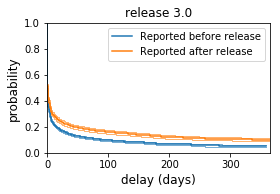

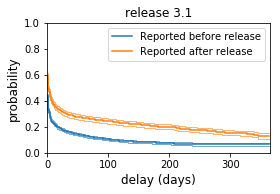

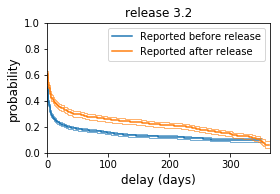

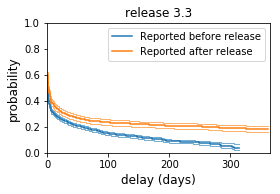

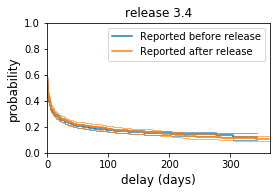

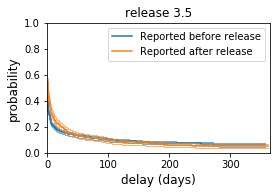

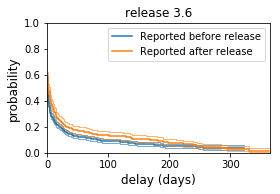

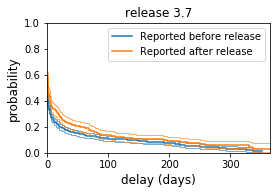

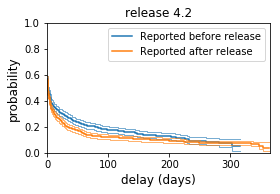

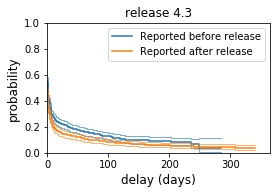

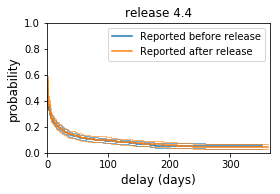

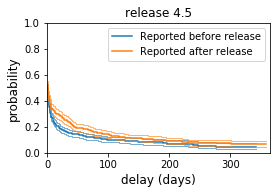

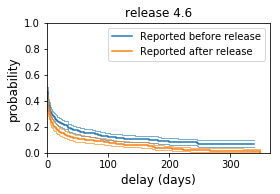

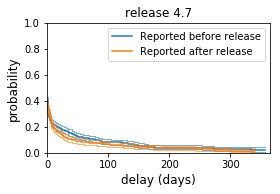

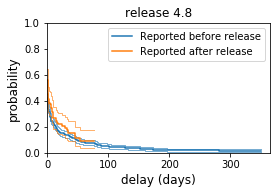

In [14]:
pData = pd.DataFrame()
for release in all_data.release.unique():
    plt.figure(figsize=(4,2.8))
    ax = plt.subplot(1, 1,1)
    kmf = KaplanMeierFitter()
    
    data = all_data[all_data['release']==release]
    
    T = data["triaging_time"]
    E = data["done"]

    dem = (data["period"] == "before")

    kmf.fit(T[dem], event_observed=E[dem], label="Reported before release")
    kmf.plot(ax=ax,ci_force_lines=True)
    kmf.fit(T[~dem], event_observed=E[~dem], label="Reported after release")
    kmf.plot(ax=ax,ci_force_lines=True)

    plt.title('release '+release,fontsize=12)
    plt.xlabel('delay (days)',fontsize=12)
    plt.ylabel('probability',fontsize=12)
    plt.xlim(0, 365)
    plt.ylim(0, 1)
    plt.tight_layout( )
    
    plt.savefig(FIGS_PATH+os.sep+'triage_survival_'+release.replace('.', '_')+'.pdf')
    
    results = logrank_test(T[dem], T[~dem], E[dem], E[~dem], alpha=.99)
    pData = pData.append({'release':str(release),
                         'p':results.p_value},ignore_index=True)

In [15]:
pData['H0'] = pData.apply(lambda x: 'reject H0' if x['p'] <0.05 else 'can not reject H0', axis=1)
pData

,p,release,H0
0,1.725265e-16,3.0,reject H0
1,7.282718e-49,3.1,reject H0
2,9.228699e-23,3.2,reject H0
3,1.957731e-16,3.3,reject H0
4,6.265608e-01,3.4,can not reject H0
5,9.315317e-03,3.5,reject H0
6,4.185790e-04,3.6,reject H0
7,1.655912e-03,3.7,reject H0
8,1.506813e-03,4.2,reject H0
9,7.374029e-04,4.3,reject H0


In [16]:
pData.to_csv('data'+os.sep+'RQ2'+os.sep+'triage-logrank_test-v2.zip',index=False,compression='zip')

# rolling release

In [17]:
tfile2 = 'data'+os.sep+'RQ2'+os.sep+'rolling_releases_yearly_stats_first_assign-v2.zip'
if not os.path.exists(tfile2):
    df_yearly_stats_first_rolling = get_triaging_statistics_per_release_rolling(df_rolling,assignedFirst=True,resolvedFirst=False)
    df_yearly_stats_first_rolling.to_csv(tfile2,index=False,compression='zip')
else:
    df_yearly_stats_first_rolling = pd.read_csv(tfile2,index_col=False,compression='zip',
                                       dtype={'version': str,'release':str})
    df_yearly_stats_first_rolling["RAAA"]  = df_yearly_stats_first_rolling["RAAA"].apply(ast.literal_eval)
    df_yearly_stats_first_rolling["RBAA"]  = df_yearly_stats_first_rolling["RBAA"].apply(ast.literal_eval)
    df_yearly_stats_first_rolling["RBAB"]  = df_yearly_stats_first_rolling["RBAB"].apply(ast.literal_eval)
    df_yearly_stats_first_rolling["RANA"]  = df_yearly_stats_first_rolling["RANA"].apply(ast.literal_eval)
    
df_yearly_stats_first_rolling['version'] = df_yearly_stats_first_rolling['version'].astype(str)
df_yearly_stats_first_rolling = sort_df(df_yearly_stats_first_rolling,'version')
df_yearly_stats_first_rolling.head()

,version,RAAA,RANA,RBAA,RBAB,after_release,before_release,total
0,4.9,"[539232, 539274, 539308, 539331, 539392, 53940...","[539414, 539706, 539707, 539869, 540817, 54247...","[539191, 536193, 537642, 538199, 538240, 53838...","[535977, 535992, 536027, 536168, 536185, 53620...",341.0,392.0,791.0
1,4.10,"[542946, 543219, 543245, 543609, 543629, 54364...",[],"[540478, 540482, 541232, 541473, 541862, 54254...","[540097, 540200, 540260, 540474, 540580, 54069...",179.0,389.0,572.0


In [ ]:
#traiging_time_RBAB=pd.DataFrame()
traiging_time_RB=pd.DataFrame()
traiging_time_RA=pd.DataFrame()
for index, row in df_yearly_stats_first_rolling.iterrows():
    #the bug created and assigned & before release  
   # print(type(row['RBAB']))
   # print(row['RBAB'])
    release=str(row['version'])
    
    #print(release)
    df_b=df_all[df_all.id.isin(row['RBAB'])]
    #print(len(df_b))
    if len(df_b)>0:
 
        df_b=trans_to_datetime(df_b,['creation_time','first_assignment_date'])
        df_b['triaging_time'] =df_b.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'first_assignment_date',
         'triaging_time' ,'release' ]]
        df_b['done'] = '1'
        traiging_time_RB=traiging_time_RB.append(df_b)
    #the bug created before and assigned after release  
    df_b=df_all[df_all.id.isin(row['RBAA'])]
    if len(df_b)>0:

   
        df_b=trans_to_datetime(df_b,['creation_time','first_assignment_date'])

        date=datetime.strptime(release_creation_ts_all[release], '%Y-%m-%d %H:%M:%S')
        df_b['triaging_time'] =df_b.apply(lambda x : (date-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'first_assignment_date',
         'triaging_time' ,'release' ]]
        df_b['done'] = '0'
        traiging_time_RB=traiging_time_RB.append(df_b)
    
    
    #the bug created and assigned & after release 
    df_a=df_all[df_all.id.isin(row['RAAA'])]
    if len(df_a)>0:

        df_a=trans_to_datetime(df_a,['creation_time','first_assignment_date']) 
        df_a['triaging_time'] =df_a.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'first_assignment_date',
         'triaging_time',
            'release']]
        df_a['done'] = '1'
        traiging_time_RA=traiging_time_RA.append(df_a)
     #the bug created after release and not assigned within 1 year
    df_a=df_all[df_all.id.isin(row['RANA'])]
    if len(df_a)>0:
        date=datetime.strptime(release_creation_ts_all[version_successor_rolling(release)], '%Y-%m-%d %H:%M:%S')

        df_a=trans_to_datetime(df_a,['creation_time','first_assignment_date']) 
        df_a['triaging_time'] =df_a.apply(lambda x : (date-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'first_assignment_date',
         'triaging_time',
            'release']]
        df_a['done'] = '0'
        traiging_time_RA=traiging_time_RA.append(df_a)
   
    #
traiging_time_RB.to_csv('data'+os.sep+'RQ2'+os.sep+'rolling_Eclipse-RB-v2.zip',index=False,compression='zip')    
traiging_time_RA.to_csv('data'+os.sep+'RQ2'+os.sep+'rolling_Eclipse-RA-v2.zip',index=False,compression='zip')

0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64


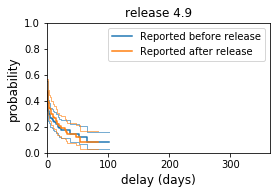

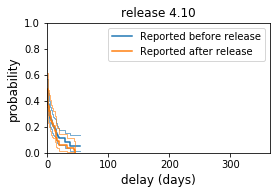

In [19]:
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'rolling_Eclipse-RB-v2.zip',index_col=False,compression='zip',dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'rolling_Eclipse-RA-v2.zip',index_col=False,compression='zip',dtype={'release':str})

RBAB['period'] = 'before'
RAAA['period'] = 'after'
all_data = pd.DataFrame()
all_data = all_data.append(RBAB,ignore_index=True)
all_data = all_data.append(RAAA,ignore_index=True) 
all_data

pData = pd.DataFrame()
for release in all_data.release.unique():
    plt.figure(figsize=(4,2.8))
    ax = plt.subplot(1, 1,1)
    kmf = KaplanMeierFitter()
    
    data = all_data[all_data['release']==release]
    
    T = data["triaging_time"]
    E = data["done"]

    dem = (data["period"] == "before")

    kmf.fit(T[dem], event_observed=E[dem], label="Reported before release")
    kmf.plot(ax=ax,ci_force_lines=True)
    kmf.fit(T[~dem], event_observed=E[~dem], label="Reported after release")
    kmf.plot(ax=ax,ci_force_lines=True)

    plt.title('release '+release,fontsize=12)
    plt.xlabel('delay (days)',fontsize=12)
    plt.ylabel('probability',fontsize=12)
    plt.xlim(0, 365)
    plt.ylim(0, 1)
    plt.tight_layout( )
    
    plt.savefig(FIGS_PATH+os.sep+'triage_survival_'+release.replace('.', '_')+'.pdf')
    
    results = logrank_test(T[dem], T[~dem], E[dem], E[~dem], alpha=.99)
    pData = pData.append({'release':str(release),
                         'p':results.p_value},ignore_index=True)

In [20]:
pData['H0'] = pData['p'].apply(lambda x: 'reject H0' if x <0.01 else 'can not reject H0')
pData

,p,release,H0
0,0.862668,4.9,can not reject H0
1,0.499516,4.10,can not reject H0


# FIXING TIMES

In [21]:
def get_fixing_statistics_per_release(df_w,assignedFirst,fixedLast):
    df_ret=pd.DataFrame()
    df_w['release'] = df_w['release'].astype(str)
    
    if assignedFirst:
        assingment_column = 'first_assignment_date'
    else:
        assingment_column = 'last_assignment_date'
        
        
    if fixedLast:
        fix_column = 'first_fixed_date'
    else:
        fix_column = 'last_fixed_date'
        
    for version in df_w.release.unique():
        start_date = release_creation_ts_all[version]
        start_date = pd.to_datetime(start_date)
        if version=='3.0':
            end_date_before=addYears(start_date,-1)
            end_date_after=datetime.strptime(release_creation_ts_all[version_successor(version)], '%Y-%m-%d %H:%M:%S')
        else:
            end_date_before=datetime.strptime(release_creation_ts_all[version_predecessor(version)], '%Y-%m-%d %H:%M:%S')
            end_date_after=datetime.strptime(release_creation_ts_all[version_successor(version)], '%Y-%m-%d %H:%M:%S')                
        
        #Fetch the bugs of this version
        version_bugs = df_w[df_w['release']==version]
        version_bugs = trans_to_datetime(version_bugs,
                                        ['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date', 'last_fixed_date'])

        #the bug before release 
        bugs_before_release = version_bugs[(version_bugs['creation_time']<start_date) & (version_bugs['creation_time']>=end_date_before) ]
        
        #the bug after release 
        bugs_after_release = version_bugs[(version_bugs['creation_time']>= start_date) & (version_bugs['creation_time']< end_date_after)]
        
        #the bug created and assigned & before release 
        bugs_created_fixed_before_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) 
                         & (version_bugs[fix_column]<start_date)]
        )   
   

        #the bug created before release and assigned  after release 
        bugs_created_before_fixed_after_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[fix_column] >= start_date )]
        )



        #the bug created after release  and assigned
        bugs_created_after_release_fixed = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                       (version_bugs[fix_column] <= end_date_after )]
        )
                #the bug created after release  and assigned
        bugs_created_after_release_not_fixed = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs[fix_column] > end_date_after )]
        )

        before_release = len(bugs_before_release.id.unique())
        RBFB= bugs_created_fixed_before_release.id.unique().tolist()
        RBFA =  bugs_created_before_fixed_after_release.id.unique().tolist()
        after_release = len(bugs_after_release.id.unique())
        RAFA = bugs_created_after_release_fixed.id.unique().tolist()
        RANF = bugs_created_after_release_not_fixed.id.unique().tolist()
       
  
        df_ret=df_ret.append({"version": version , 
                           "total": len(version_bugs.id.unique()) ,
                           'before_release': before_release, 
                           'after_release':after_release, 
                           'RBFB':RBFB, 
                           'RBFA':RBFA, 
                           'RAFA':RAFA,
                           'RANF':RANF
                            },ignore_index=True)
    return df_ret

In [22]:
#Load data
df_all = pd.read_csv('.'+os.sep+'data'+os.sep+'bugs_info.zip',index_col=False,compression='zip',dtype={'release':str,'version':str})
df_all = df_all.fillna('')
df_all = trans_to_datetime(df_all,['creation_time','first_assignment_date','last_assignment_date',
                          'first_resolved_date','last_resolved_date',
                           'first_fixed_date','last_fixed_date'])
df_all.head(n=2)

#all expect these in rolling releases
df=df_all[(df_all['release']!='4.9') & (df_all['release']!='4.10')]
#bugs in rolling release
df_rolling=df_all[(df_all['release']=='4.9') | (df_all['release']=='4.10')]

In [23]:
tfile3 = 'data'+os.sep+'RQ2'+os.sep+'year_releases_yearly_stats_last_fix-v2.zip'

if not os.path.exists(tfile3):
    df_yearly_stats_first = get_fixing_statistics_per_release(df,assignedFirst=True,fixedLast=False)
    df_yearly_stats_first.to_csv(tfile3,index=False,compression='zip')
else:
    df_yearly_stats_first = pd.read_csv(tfile3,index_col=False,compression='zip',
                                       dtype={'version': str,'release':str})
    df_yearly_stats_first["RBFB"]  = df_yearly_stats_first["RBFB"].apply(ast.literal_eval)
    df_yearly_stats_first["RBFA"]  = df_yearly_stats_first["RBFA"].apply(ast.literal_eval)
    df_yearly_stats_first["RAFA"]  = df_yearly_stats_first["RAFA"].apply(ast.literal_eval)
    df_yearly_stats_first["RANF"]  = df_yearly_stats_first["RANF"].apply(ast.literal_eval)
    
df_yearly_stats_first = sort_df(df_yearly_stats_first,'version')
df_yearly_stats_first.head()

,version,RAFA,RANF,RBFA,RBFB,after_release,before_release,total
0,3.0,"[100923, 101160, 82566, 82589, 82623, 82627, 8...","[101046, 101688, 82769, 82937, 82972, 83458, 8...","[64612, 64639, 64664, 64686, 64691, 64707, 647...","[64614, 64617, 64626, 64627, 64629, 64633, 646...",6534.0,17758.0,24937.0
1,3.1,"[102002, 102080, 102081, 102088, 102097, 10210...","[102099, 102170, 102192, 102201, 102366, 10244...","[100816, 100875, 100889, 100908, 100916, 10092...","[100822, 100823, 100825, 100829, 100867, 10092...",5264.0,12168.0,17908.0
2,3.2,"[183758, 183829, 185263, 185386, 185559, 18647...","[183675, 184063, 184345, 184507, 184932, 18521...","[103301, 103650, 103809, 104795, 139854, 13986...","[102324, 103299, 104892, 104902, 105132, 10524...",4771.0,10334.0,15834.0
3,3.3,"[237486, 237701, 237824, 237830, 223285, 22333...","[236605, 236630, 236991, 237220, 237517, 23761...","[183730, 183810, 183830, 183866, 183963, 18402...","[183596, 183599, 183607, 183610, 183621, 18362...",4141.0,8050.0,12642.0
4,3.4,"[244322, 244396, 244397, 244425, 244428, 24447...","[244409, 244757, 244833, 245008, 245388, 24557...","[236612, 236615, 236628, 236634, 236666, 23668...","[236669, 236844, 236922, 237034, 237106, 23713...",3908.0,7891.0,12510.0


In [24]:
#fixing_time_RBAB=pd.DataFrame()
fixing_time_RB=pd.DataFrame()
fixing_time_RA=pd.DataFrame()
for index, row in df_yearly_stats_first.iterrows():
    #the bug created and assigned & before release  
    release=str(row['version'])
    
    df_b=df_all[df_all.id.isin(row['RBFB'])]
    if len(df_b)>0:
        df_b=trans_to_datetime(df_b,['creation_time','last_fixed_date'])
        df_b['fixing_time'] =df_b.apply(lambda x : (x['last_fixed_date']-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'last_fixed_date',
         'fixing_time' ,'release' ]]
        df_b['done'] = '1'
        fixing_time_RB=fixing_time_RB.append(df_b)
        
    #the bug created before and assigned after release  
    df_b=df_all[df_all.id.isin(row['RBFA'])]
    if len(df_b)>0:
   
        df_b=trans_to_datetime(df_b,['creation_time','last_fixed_date'])

        date=datetime.strptime(release_creation_ts_all[release], '%Y-%m-%d %H:%M:%S')
        df_b['fixing_time'] =df_b.apply(lambda x : (date-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'last_fixed_date',
         'fixing_time' ,'release' ]]
        df_b['done'] = '0'
        fixing_time_RB=fixing_time_RB.append(df_b)
    
    
    #the bug created and assigned & after release 
    df_a=df_all[df_all.id.isin(row['RAFA'])]
    if len(df_a)>0:

        df_a=trans_to_datetime(df_a,['creation_time','last_fixed_date']) 
        df_a['fixing_time'] =df_a.apply(lambda x : (x['last_fixed_date']-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'last_fixed_date',
         'fixing_time',
            'release']]
        df_a['done'] = '1'
        fixing_time_RA=fixing_time_RA.append(df_a)
     #the bug created after release and not assigned within 1 year
    df_a=df_all[df_all.id.isin(row['RANF'])]
    if len(df_a)>0:
        date=datetime.strptime(release_creation_ts_all[version_successor(release)], '%Y-%m-%d %H:%M:%S')

        df_a=trans_to_datetime(df_a,['creation_time','last_fixed_date']) 
        df_a['fixing_time'] =df_a.apply(lambda x : (date-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'last_fixed_date',
         'fixing_time',
            'release']]
        df_a['done'] = '0'
        fixing_time_RA=fixing_time_RA.append(df_a)
   
    #
fixing_time_RB.to_csv('data'+os.sep+'RQ2'+os.sep+'fix-Eclipse-FB-v2.zip',compression='zip',index=False)    
fixing_time_RA.to_csv('data'+os.sep+'RQ2'+os.sep+'fix-Eclipse-FA-v2.zip',compression='zip',index=False)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64


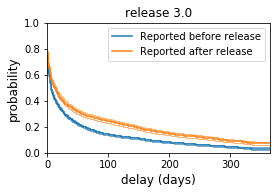

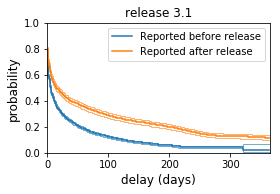

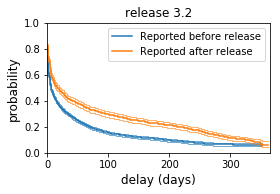

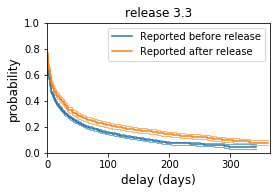

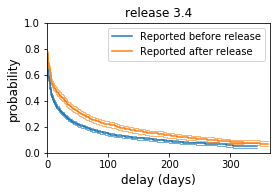

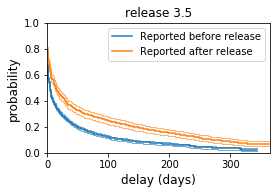

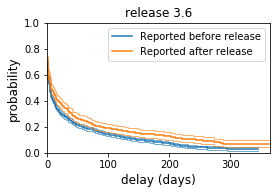

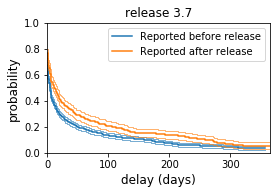

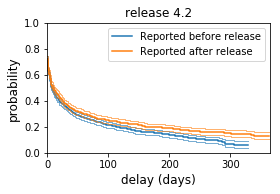

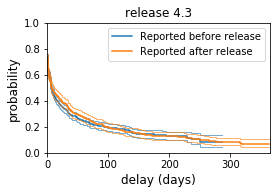

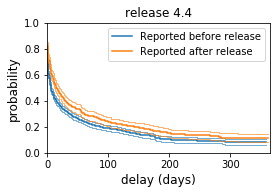

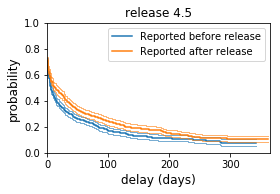

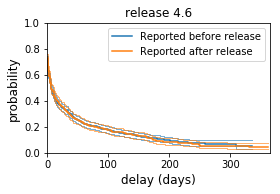

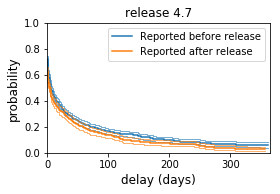

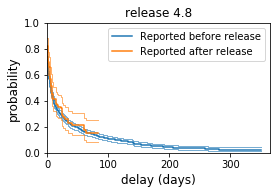

In [25]:
RBFB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'fix-Eclipse-FB-v2.zip',index_col=False,compression='zip',dtype={'release':str})
RAFA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'fix-Eclipse-FA-v2.zip',index_col=False,compression='zip',dtype={'release':str})

RBFB['period'] = 'before'
RAFA['period'] = 'after'
all_data = pd.DataFrame()
all_data = all_data.append(RBFB,ignore_index=True)
all_data = all_data.append(RAFA,ignore_index=True) 
all_data

pData = pd.DataFrame()
for release in all_data.release.unique():
    plt.figure(figsize=(4,2.8))
    ax = plt.subplot(1, 1,1)
    kmf = KaplanMeierFitter()
    
    data = all_data[all_data['release']==release]
    
    T = data["fixing_time"]
    E = data["done"]

    dem = (data["period"] == "before")

    kmf.fit(T[dem], event_observed=E[dem], label="Reported before release")
    kmf.plot(ax=ax,ci_force_lines=True)
    kmf.fit(T[~dem], event_observed=E[~dem], label="Reported after release")
    kmf.plot(ax=ax,ci_force_lines=True)

    plt.title('release '+release,fontsize=12)
    plt.xlabel('delay (days)',fontsize=12)
    plt.ylabel('probability',fontsize=12)
    plt.xlim(0, 365)
    plt.ylim(0, 1)
    plt.tight_layout( )
    
    plt.savefig(FIGS_PATH+os.sep+'fix_survival_'+release.replace('.', '_')+'.pdf')
    
    results = logrank_test(T[dem], T[~dem], E[dem], E[~dem], alpha=.99)
    pData = pData.append({'release':str(release),
                         'p':results.p_value},ignore_index=True)

In [26]:
pData['H0'] = pData['p'].apply(lambda x: 'reject H0' if x <0.01 else 'can not reject H0')
pData

,p,release,H0
0,3.969618e-29,3.0,reject H0
1,8.534698e-61,3.1,reject H0
2,2.328729e-32,3.2,reject H0
3,2.902782e-11,3.3,reject H0
4,8.419665e-15,3.4,reject H0
5,8.668323e-23,3.5,reject H0
6,5.670033e-05,3.6,reject H0
7,3.645048e-07,3.7,reject H0
8,8.863896e-03,4.2,reject H0
9,5.374553e-01,4.3,can not reject H0


In [27]:
pData.to_csv('data'+os.sep+'RQ2'+os.sep+'fix-logrank_test-v2.zip',index=False,compression='zip')

In [28]:
def get_fixing_statistics_per_release_rolling(df_w,assignedFirst,resolvedFirst):
    #Calculate traiging time per release
    df_ret=pd.DataFrame()
    df_w['release'] = df_w['release'].astype(str)
    
    if assignedFirst:
        assingment_column = 'first_assignment_date'
    else:
        assingment_column = 'last_assignment_date'
        
        
    if resolvedFirst:
        fix_column = 'first_fixed_date'
    else:
        fix_column = 'last_fixed_date'
        
        
    for version in df_w.release.unique():
        start_date = release_creation_ts_all[version]
        start_date = pd.to_datetime(start_date)
        
        end_date_before=addYears(start_date,-1)
        end_date_after=datetime.strptime(temp_rolling[version_successor_rolling(version)], '%Y-%m-%d %H:%M:%S')

        #Fetch the bugs of this version
        version_bugs = df_w[df_w['release']==version]
        
        version_bugs = trans_to_datetime(version_bugs,
                                        ['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date', 'last_fixed_date'])

        #the bug before release 
        bugs_before_release = version_bugs[(version_bugs['creation_time']<start_date) & (version_bugs['creation_time']>=end_date_before) ]
        
        #the bug after release 
        bugs_after_release = version_bugs[(version_bugs['creation_time']>= start_date) & (version_bugs['creation_time']< end_date_after)]
        
        #the bug created and assigned & before release 
        bugs_created_fixed_before_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[fix_column]<start_date)]
        )   
   
        #the bug created before release and assigned  after release 
        bugs_created_before_fixed_after_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[fix_column] > start_date )]
        )

        #the bug created after release  and assigned
        bugs_created_after_release_fixed = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs[fix_column] <= end_date_after )]
        )
                #the bug created after release  and assigned
        bugs_created_after_release_not_fixed = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs[fix_column] > end_date_after )]
        )

        before_release = len(bugs_before_release.id.unique())
        RBFB= bugs_created_fixed_before_release.id.unique().tolist()
        RBFA = bugs_created_before_fixed_after_release.id.unique().tolist()
        after_release = len(bugs_after_release.id.unique())
        RAFA = bugs_created_after_release_fixed.id.unique().tolist()
        RANF = bugs_created_after_release_not_fixed.id.unique().tolist()
       
  
        df_ret=df_ret.append({"version": version , 
                           "total": len(version_bugs.id.unique()) ,
                           'before_release': before_release, 
                           'after_release':after_release, 
                           'RBFB':RBFB, 
                           'RBFA':RBFA, 
                           'RAFA':RAFA,
                           'RANF':RANF
                            },ignore_index=True)
    return df_ret

In [29]:
tfile4 = 'data'+os.sep+'RQ2'+os.sep+'rolling_releases_yearly_stats_last_fix-v2.zip'
if not os.path.exists(tfile4):
    df_yearly_stats_first_rolling = get_fixing_statistics_per_release_rolling(df_rolling,assignedFirst=True,resolvedFirst=False)
    df_yearly_stats_first_rolling.to_csv(tfile4,index=False,compression='zip')
else:
    df_yearly_stats_first_rolling = pd.read_csv(tfile4,index_col=False,compression='zip',
                                       dtype={'version': str,'release':str})
    df_yearly_stats_first_rolling["RAFA"]  = df_yearly_stats_first_rolling["RAFA"].apply(ast.literal_eval)
    df_yearly_stats_first_rolling["RBFA"]  = df_yearly_stats_first_rolling["RBFA"].apply(ast.literal_eval)
    df_yearly_stats_first_rolling["RBFB"]  = df_yearly_stats_first_rolling["RBFB"].apply(ast.literal_eval)
    df_yearly_stats_first_rolling["RANF"]  = df_yearly_stats_first_rolling["RANF"].apply(ast.literal_eval)
    
df_yearly_stats_first_rolling = sort_df(df_yearly_stats_first_rolling,'version')
df_yearly_stats_first_rolling.head()

,version,RAFA,RANF,RBFA,RBFB,after_release,before_release,total
0,4.9,"[539232, 539236, 539274, 539276, 539280, 53928...","[539414, 539418, 539706, 539707, 539724, 53986...","[539164, 539167, 539191, 536193, 536393, 53695...","[539197, 535977, 535992, 536027, 536028, 53606...",341.0,392.0,791.0
1,4.10,"[542922, 542940, 542946, 543219, 543222, 54324...",[],"[540478, 540482, 540675, 541025, 541119, 54120...","[540026, 540083, 540097, 540118, 540124, 54020...",179.0,389.0,572.0


In [30]:
fixing_time_RB=pd.DataFrame()
fixing_time_RA=pd.DataFrame()
for index, row in df_yearly_stats_first_rolling.iterrows():
    release=str(row['version'])
    
    df_b=df_all[df_all.id.isin(row['RBFB'])]
    if len(df_b)>0:
 
        df_b=trans_to_datetime(df_b,['creation_time','last_fixed_date'])
        df_b['fixing_time'] =df_b.apply(lambda x : (x['last_fixed_date']-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'last_fixed_date',
         'fixing_time' ,'release' ]]
        df_b['done'] = '1'
        fixing_time_RB=fixing_time_RB.append(df_b)
    #the bug created before and assigned after release  
    df_b=df_all[df_all.id.isin(row['RBFA'])]
    if len(df_b)>0:
        df_b=trans_to_datetime(df_b,['creation_time','last_fixed_date'])

        date=datetime.strptime(release_creation_ts_all[release], '%Y-%m-%d %H:%M:%S')
        df_b['fixing_time'] =df_b.apply(lambda x : (date-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'last_fixed_date',
         'fixing_time' ,'release' ]]
        df_b['done'] = '0'
        fixing_time_RB=fixing_time_RB.append(df_b)
    
    
    #the bug created and fixed & after release 
    df_a=df_all[df_all.id.isin(row['RAFA'])]
    if len(df_a)>0:

        df_a=trans_to_datetime(df_a,['creation_time','last_fixed_date']) 
        df_a['fixing_time'] =df_a.apply(lambda x : (x['last_fixed_date']-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'last_fixed_date',
         'fixing_time',
            'release']]
        df_a['done'] = '1'
        fixing_time_RA=fixing_time_RA.append(df_a)
     #the bug created after release and not assigned within 1 year
    df_a=df_all[df_all.id.isin(row['RANF'])]
    if len(df_a)>0:
        date=datetime.strptime(release_creation_ts_all[version_successor_rolling(release)], '%Y-%m-%d %H:%M:%S')

        df_a=trans_to_datetime(df_a,['creation_time','last_fixed_date']) 
        df_a['fixing_time'] =df_a.apply(lambda x : (date-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'last_fixed_date',
         'fixing_time',
            'release']]
        df_a['done'] = '0'
        fixing_time_RA=fixing_time_RA.append(df_a)
   
    #
fixing_time_RB.to_csv('data'+os.sep+'RQ2'+os.sep+'rolling_fix-Eclipse-FB-v2.zip',index=False,compression='zip')    
fixing_time_RA.to_csv('data'+os.sep+'RQ2'+os.sep+'rolling_fix-Eclipse-FA-v2.zip',index=False,compression='zip')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64


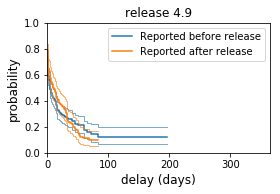

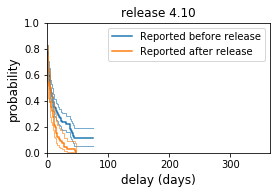

In [31]:
RBFB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'rolling_fix-Eclipse-FB-v2.zip',index_col=False,compression='zip',dtype={'release':str})
RAFA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'rolling_fix-Eclipse-FA-v2.zip',index_col=False,compression='zip',dtype={'release':str})

RBFB['period'] = 'before'
RAFA['period'] = 'after'
all_data = pd.DataFrame()
all_data = all_data.append(RBFB,ignore_index=True)
all_data = all_data.append(RAFA,ignore_index=True) 
all_data

pData = pd.DataFrame()
for release in all_data.release.unique():
    plt.figure(figsize=(4,2.8))
    ax = plt.subplot(1, 1,1)
    kmf = KaplanMeierFitter()
    
    data = all_data[all_data['release']==release]
    
    T = data["fixing_time"]
    E = data["done"]

    dem = (data["period"] == "before")

    kmf.fit(T[dem], event_observed=E[dem], label="Reported before release")
    kmf.plot(ax=ax,ci_force_lines=True)
    kmf.fit(T[~dem], event_observed=E[~dem], label="Reported after release")
    kmf.plot(ax=ax,ci_force_lines=True)

    plt.title('release '+release,fontsize=12)
    plt.xlabel('delay (days)',fontsize=12)
    plt.ylabel('probability',fontsize=12)
    plt.xlim(0, 365)
    plt.ylim(0, 1)
    plt.tight_layout( )
    
    plt.savefig(FIGS_PATH+os.sep+'fix_survival_'+release.replace('.', '_')+'.pdf')
    
    results = logrank_test(T[dem], T[~dem], E[dem], E[~dem], alpha=.99)
    pData = pData.append({'release':str(release),
                         'p':results.p_value},ignore_index=True)

In [32]:
pData['H0'] = pData['p'].apply(lambda x: 'reject H0' if x <0.01 else 'can not reject H0')
pData

,p,release,H0
0,0.778530,4.9,can not reject H0
1,0.001399,4.10,reject H0
